In [1]:
import sys
import os
import matplotlib.pyplot as plt
import numpy as np

from dotenv import load_dotenv
load_dotenv()
DATASET_PATH=os.getenv("DATASET_DIRECTORY")
CONFIG_DIRECTORY = os.getenv("CONFIG_DIRECTORY")

sys.path.append("../")
from mmwave_radar_processing.config_managers.cfgManager import ConfigManager
from cpsl_datasets.cpsl_ds import CpslDS
from mmwave_radar_processing.processors.synthetic_array_processor import SyntheticArrayProcessor
from mmwave_radar_processing.plotting.plotter_synthetic_array_data import PlotterSyntheticArrayData
from mmwave_radar_processing.plotting.movies_synthetic_array_data import MovieGeneratorSyntheticArrayData
from mmwave_radar_processing.detectors.CFAR import CaCFAR_1D,CaCFAR_2D

/home/david/.cache/pypoetry/virtualenvs/mmwave-radar-processing-ERvCMkmn-py3.10/lib/python3.10/site-packages/matplotlib/projections/__init__.py:63: UserWarning: Unable to import Axes3D. This may be due to multiple versions of Matplotlib being installed (e.g. as a system package and as a pip package). As a result, the 3D projection is not available.
  warnings.warn("Unable to import Axes3D. This may be due to multiple versions of "


In [2]:
cfg_manager = ConfigManager()

cfg_path = os.path.join(CONFIG_DIRECTORY,"RadSAR_2_sr.cfg")
cfg_manager.load_cfg(cfg_path)
cfg_manager.compute_radar_perforance(profile_idx=0)

In [3]:
#load the dataset
dataset_name = "RadSAR_2_CPSL"
dataset_path = os.path.join(DATASET_PATH,os.pardir,"RadSAR",dataset_name)
dataset = CpslDS(
    dataset_path=dataset_path,
    radar_folder="radar_0",
    lidar_folder="lidar",
    camera_folder="camera",
    imu_orientation_folder="imu_data",
    imu_full_folder="imu_data_full"
)

found 133 radar samples
found 133 lidar samples
found 133 camera samples
found 133 imu (orientation only) samples
found 133imu (full data) samples
found 133 vehicle velocity samples


In [4]:
cfar_2d = CaCFAR_2D(
    num_guard_cells=3,
    num_training_cells=10,
    false_alarm_rate=0.01,
    resp_border_cells=5,
    mode="valid"
)

alpha: 4.6207992656924635 (mag), 13.294342050765227 dB


In [5]:
cfar = CaCFAR_1D(
    config_manager=cfg_manager,
    num_guard_cells=3,
    num_training_cells=10,
    false_alarm_rate=0.01,
    resp_border_cells=5,
    mode="full"
)

processor = SyntheticArrayProcessor(
    config_manager=cfg_manager,
    cfar=cfar,
    az_angle_bins_rad=\
                np.deg2rad(np.linspace(
                    start=-30,stop=30,num=80
                 )),
    el_angle_bins_rad=\
                np.deg2rad(np.linspace(
                    start=-60,
                    stop=60,
                    num=16
                ))
)

synthetic_array_plotter = PlotterSyntheticArrayData(
    config_manager=cfg_manager,
    synthetic_array_processor=processor,
    min_vel=0.4
)

movie_generator = MovieGeneratorSyntheticArrayData(
    cpsl_dataset=dataset,
    plotter=synthetic_array_plotter,
    processor=processor,
    temp_dir_path="~/Downloads/syntheticArrays"
)

alpha: 5.178508235883346 (mag), 14.284093425677316 dB
found temp dir: /home/david/Downloads/syntheticArrays
clearing temp directory /home/david/Downloads/syntheticArrays


In [6]:
idx = 100
while np.abs(np.mean(dataset.get_vehicle_vel_data(idx)[:,1])) < 0.4:
    idx += 1
vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])

processor._generate_array_geometries(
    vels=np.array([-vel,0,0])
)
print(idx)

100


In [7]:
#get the velocity of the vehicle
vel = np.mean(dataset.get_vehicle_vel_data(idx)[:,1])

#generate the array geometry
processor._generate_array_geometries(
    vels=np.array([-vel,0,0])
)
#get the adc cube
adc_cube = dataset.get_radar_data(idx)
#compute the response
resp = processor.process(adc_cube)
dets = processor.beamformed_dets
#get the lidar pointcloud for gt comparison
lidar_pc_raw = dataset.get_lidar_point_cloud_raw(idx)

(100, 80)


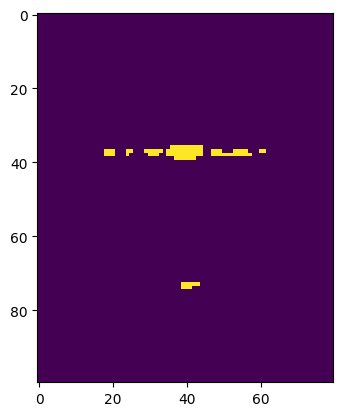

In [9]:
det_idxs,T = cfar_2d.compute(signal=resp[:,:,0])
print(det_idxs.shape)
plt.imshow(det_idxs)

alpha: 7.54008909748074 (mag), 17.54752955483744 dB


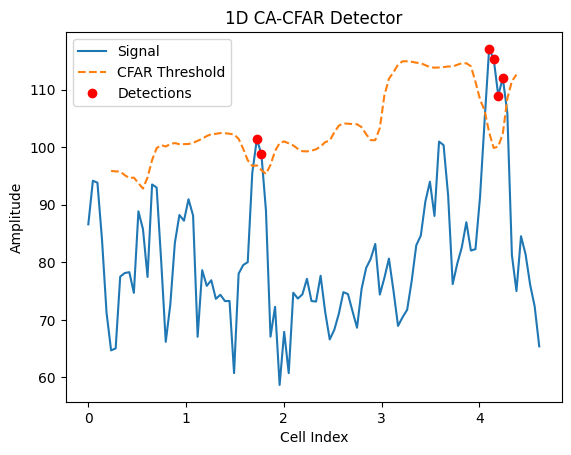

In [29]:
from mmwave_radar_processing.detectors.CFAR import CaCFAR

cfar = CaCFAR(
    config_manager=cfg_manager,
    num_guard_cells=3,
    num_training_cells=20,
    false_alarm_rate=1e-3,
    resp_border_cells=5,
    mode="full"
)

cfar.plot_cfar(
    signal=resp[:,55,10],
    show=True
)

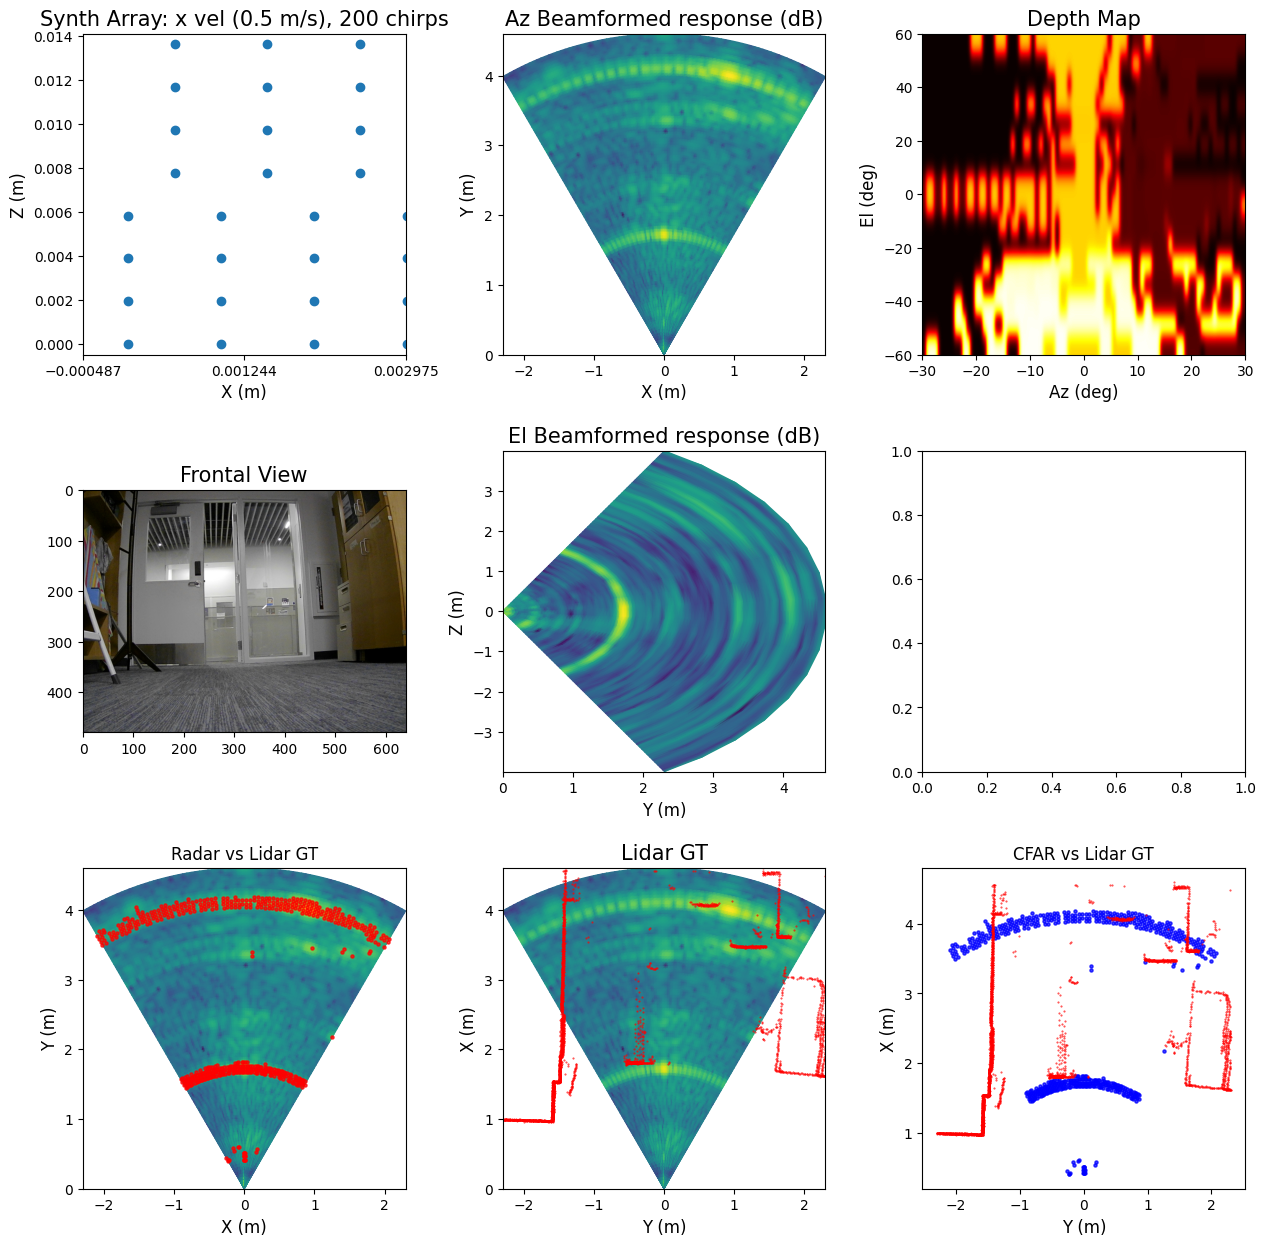

In [30]:
synthetic_array_plotter.plot_compilation(
    adc_cube=adc_cube,
    vels=np.array([-vel,0,0]),
    camera_view=dataset.get_camera_frame(idx),
    lidar_pc_raw=lidar_pc_raw,
    lidar_radar_offset_rad=np.deg2rad(180),
    convert_to_dB=True,
    cmap="viridis",
    show=True
)

  2%|▏         | 2/133 [00:00<00:49,  2.63it/s]

100%|██████████| 133/133 [00:18<00:00,  7.08it/s]


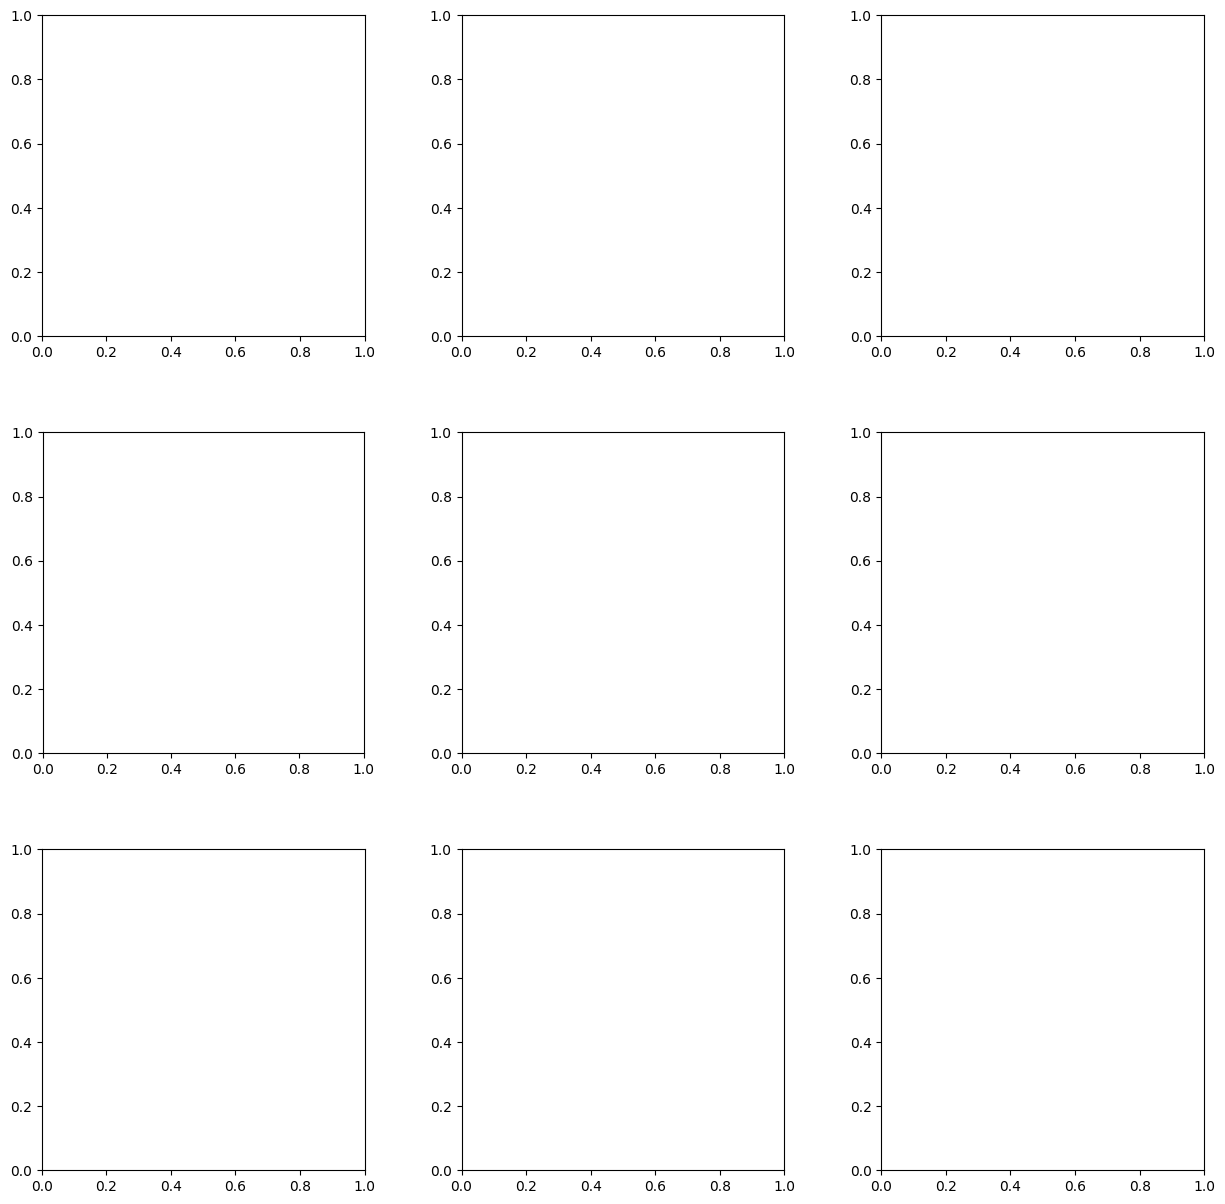

In [11]:
#generate the movie
movie_generator.initialize_figure(nrows=3,ncols=3,figsize=(15,15))

movie_generator.generate_movie_frames(
    cmap="viridis",
    convert_to_dB=True,
    lidar_radar_offset_rad=np.deg2rad(180)
)

fps = 1 / (1e-3 * cfg_manager.frameCfg_periodicity_ms)
movie_generator.save_movie(video_file_name="{}_dB.mp4".format(dataset_name),fps=fps)

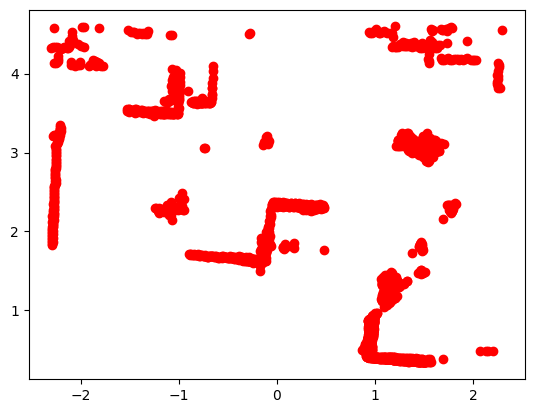

0.0


In [12]:
from mmwave_radar_processing.supportFns.rotation_functions import apply_rot_trans

#get the lidar point cloud
lidar_pc = dataset.get_lidar_point_cloud_raw(1)

#filter out the ground detections
valid_idxs = (lidar_pc[:,2] > 0.0) & \
            (lidar_pc[:,2] < 2)
lidar_pc = lidar_pc[valid_idxs,0:2]

#rotate the lidar pc into the radar's frame of view
lidar_pc = apply_rot_trans(
    lidar_pc,
    rot_angle_rad=np.deg2rad(180),
    trans=np.array([0,0])
)

#filter only the points that should be able to be seen
valid_idxs = (lidar_pc[:,0] > np.min(processor.x_s)) & \
            (lidar_pc[:,0] < np.max(processor.x_s)) & \
            (lidar_pc[:,1] > np.min(processor.y_s)) & \
            (lidar_pc[:,1] < np.max(processor.y_s)) 
lidar_pc = lidar_pc[valid_idxs,:]


fig,ax = plt.subplots()
ax.scatter(lidar_pc[:,0],lidar_pc[:,1],c="red")

plt.show()

print(np.min(processor.y_s))